<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/learn/First_order_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import scipy.linalg as la
np.set_printoptions(suppress=True)

calculating the square-root-inverse of a matrix using spectral decompostion

code from: https://people.duke.edu/~ccc14/sta-663-2016/07_LinearAlgebra2.html#Eigendecomposition

In [39]:
# matrix better be symmetric, positive definite
def is_symmetric(x): return np.all(x.T == x)

def is_pos_def(x): return np.all(np.linalg.eigvals(x) > 0)

def square_root_inverse(matrix):
    u, V = la.eig(matrix) # u: vector of eigenvalues, V: eigenvector matrix
    if is_symmetric(matrix) == False:
        print('input matrix is not symmetric'); return
    if is_pos_def(matrix) == False:
        print('input matrix is not positive definite, eigenvalues < 0')
        u = abs(u); return
    u = np.sqrt(u)
    return V@np.diag(u)@la.inv(V)

"""TEST CODE"""
A = np.array([[10,2], [2,10]])
result = square_root_inverse(A)
result@result, A

(array([[10.+0.j,  2.+0.j],
        [ 2.+0.j, 10.+0.j]]),
 array([[10,  2],
        [ 2, 10]]))

In [36]:
A = np.array([[1,5,-2],
              [5,4,5],
              [-2,5,1]])
result = square_root_inverse(A)
result

input matrix is not positive definite, eigenvalues < 0


array([[2.18252198, 0.18350342, 0.45047118],
       [0.18350342, 2.81649658, 0.18350342],
       [0.45047118, 0.18350342, 2.18252198]])

In [40]:
import torch
# https://justindomke.wordpress.com/2009/01/17/hessian-vector-products/
a = torch.tensor(2., requires_grad=True)
b = a * a
c = a + 1
b

tensor(4., grad_fn=<MulBackward0>)

In [45]:
grad_out = torch.ones_like(a)
db_da = torch.autograd.grad(b, a, grad_out, retain_graph=True)
dc_da = torch.autograd.grad(c, a, grad_out, retain_graph=True)
dbc_da = torch.autograd.grad((b, c), a, (grad_out, grad_out))

In [46]:
db_da, dbc_da, dc_da

((tensor(4.),), (tensor(5.),))

Epoch: 1, Loss: 0.1865490972995758
Here a: Parameter containing:
tensor(0.6894, requires_grad=True), b: Parameter containing:
tensor(0.0202, requires_grad=True)


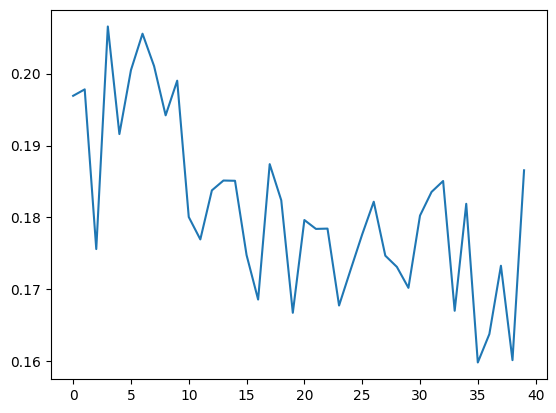

Epoch: 51, Loss: 0.003068947698920965
Here a: Parameter containing:
tensor(0.5866, requires_grad=True), b: Parameter containing:
tensor(0.0261, requires_grad=True)


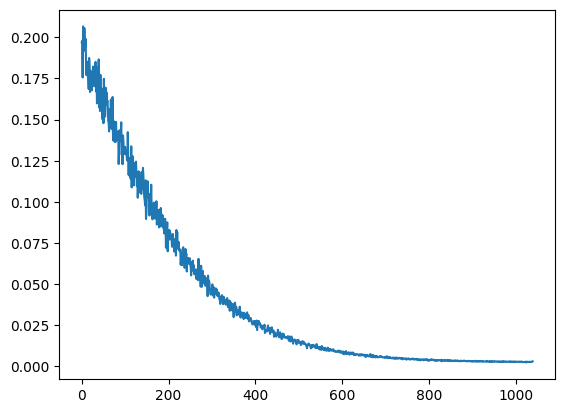

Final a: Parameter containing:
tensor(0.5833, requires_grad=True), b: Parameter containing:
tensor(0.0314, requires_grad=True)


In [128]:
# https://gist.github.com/crowsonkb/fc08028bc4907820626bea4f34bbe63b
import torch
from torch import nn, optim
from torch.utils import data
import matplotlib.pyplot as plt

class NNTest(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(0.7))
        self.b = torch.nn.Parameter(torch.tensor(0.02))
    def forward(self, x):
        return torch.cos(self.a*x[:,0]) + torch.exp(self.b * x[:, 1])

x1 = torch.rand(10000) * 10
x2 = torch.rand(10000) * 2 - 1
x = torch.stack([x1, x2], dim=-1)
y = torch.cos(0.583 * x1) + torch.exp(0.112 * x2)
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=512, shuffle=True)


model = NNTest()
opt = optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
loss_all = []

for epoch in range(100):
    model.train()
    for inp, out in loader:
        opt.zero_grad()
        loss = loss_fn(model(inp), out)
        loss.backward()
        opt.step()
        loss_all.append(loss.item())
    if (epoch - 1) % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}');
        print(f'Here a: {model.a}, b: {model.b}')
        plt.plot(loss_all); plt.show(); plt.close()

print(f'Final a: {model.a}, b: {model.b}')

$F = \frac{Dose}{V} \cdot \frac{ka}{ka-k} (e^{-kt} - e^{-ka \cdot t})$

7.440476190476192


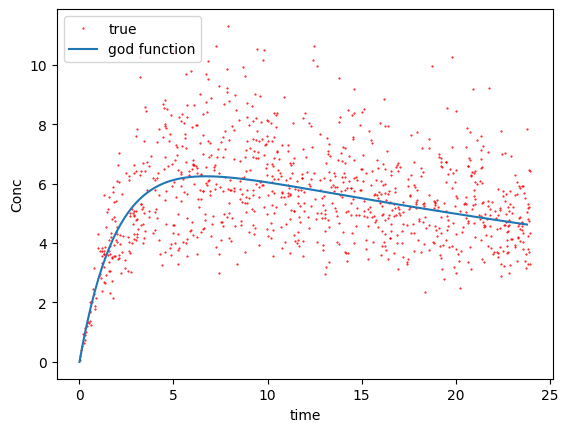

In [156]:
# https://gist.github.com/crowsonkb/fc08028bc4907820626bea4f34bbe63b
import torch
from torch import nn, optim
from torch.utils import data
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
Dose = 100
ka = 0.5
k = 0.02
V = 14
MAX_T = 24
param_ = Dose/V * ka / (ka-k)

sigma_eps = 0.5

patience = 1000
print(param_)
N = 1000 # sample number
MAX_EPOCH = 100000
verbose_freq = 1000
model_path_ = 'test.pt'
class NNTest(nn.Module):
    def __init__(self):
        super().__init__()
        self.param_ = torch.nn.Parameter(torch.tensor(0.7))
        self.ka = torch.nn.Parameter(torch.tensor(0.02))
        self.k  = torch.nn.Parameter(torch.tensor(0.2))

    def forward(self, t, Dose = 100):
        return self.param_ * (torch.exp(-1.0 * self.k * t) - torch.exp(-1.0 * self.ka * t))
        # return torch.cos(self.ka*x[:,0]) + torch.exp(self.k * x[:, 1])


t = torch.rand(N) * MAX_T
err = torch.randn(N) * sigma_eps * sigma_eps
y = param_ * (torch.exp(-1.0 * k * t) - np.exp(-1.0 * ka * t)) * np.exp(err)
plt.plot(t, y, 'ro', label='true', markersize=0.5)
# plt.set_label('predicted values')

# plt.plot(inp_list, oup_list,  'ro', label='true', markersize=0.5)
# plt.label('true values')
time_here = np.arange(0, MAX_T, 0.2)
def conc_time(t):
    return param_ * (np.exp(-1.0 * k * t) - np.exp(-1.0 * ka * t))

plt.plot(time_here, conc_time(time_here), label='god function')
plt.xlabel('time')
plt.ylabel('Conc')

plt.legend(loc=2)
plt.show()
plt.close()

  0%|          | 1/1000 [00:00<01:50,  9.01it/s]

Epoch: 1, Loss: 38.35868835449219
Here param_(true=7.440): 0.681, ka(0.5): 0.039, k(0.02): 0.180


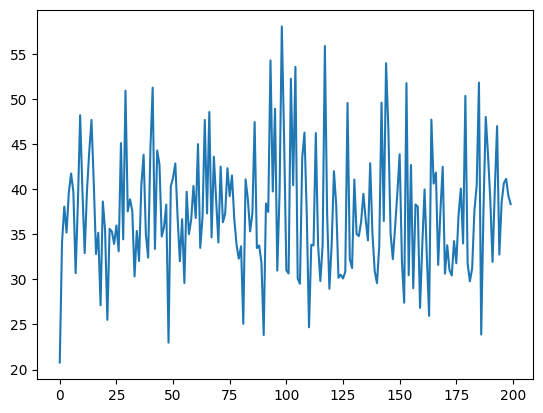

1001it [02:04,  7.22it/s]                          

Epoch: 1001, Loss: 1.8313804864883423
Here param_(true=7.440): 6.584, ka(0.5): 0.649, k(0.02): 0.010


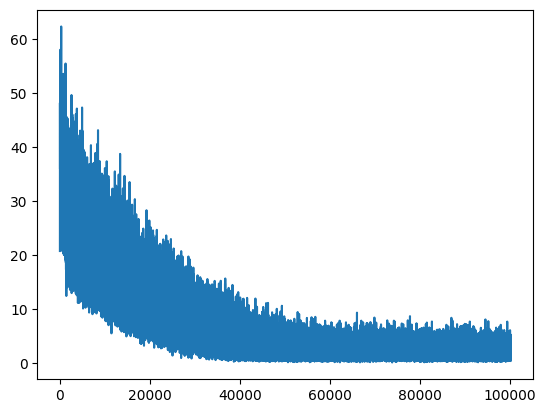

2001it [04:08,  8.87it/s]

Epoch: 2001, Loss: 1.4151349067687988
Here param_(true=7.440): 7.373, ka(0.5): 0.520, k(0.02): 0.017


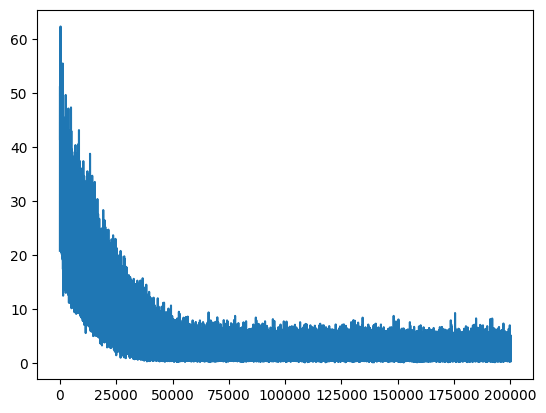

3001it [06:07,  6.92it/s]

Epoch: 3001, Loss: 2.458441972732544
Here param_(true=7.440): 7.595, ka(0.5): 0.493, k(0.02): 0.019


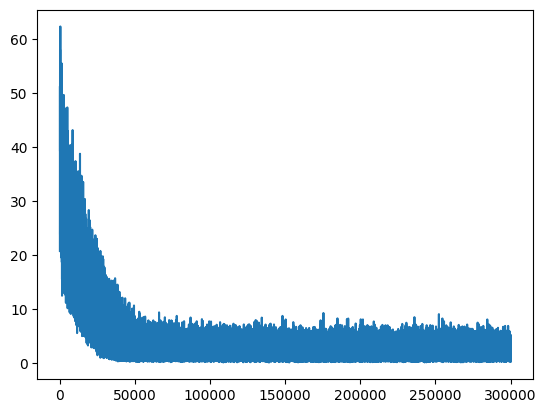

3083it [06:17,  8.16it/s]

early stop


In [157]:
dataset = data.TensorDataset(t, y)
loader = data.DataLoader(dataset, batch_size=10, shuffle=True)

model = NNTest()
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
loss_all = []

min_loss = np.inf
min_epoc = 0

for epoch in tqdm(range(MAX_EPOCH), total=MAX_EPOCH):
    model.train()
    for inp, out in loader:
        # print(inp.shape, out.shape)
        opt.zero_grad()
        loss = loss_fn(model(inp), out)
        loss.backward()
        opt.step()
        for p in model.parameters(): p.data.clamp_(0.0, 100)
        loss_all.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), model_path_)
    if epoch - min_epoch > patience: print('early stop'); break

    if (epoch - 1) % verbose_freq == 0:
        print(f'Epoch: {epoch}, Loss: {loss}');
        print(f'Here param_(true={param_:.3f}): {model.param_.item():.3f},',
              f'ka({ka}): {model.ka.item():.3f}, k({k}): {model.k.item():.3f}')
        plt.plot(loss_all); plt.show(); plt.close()

# print(f'Final a: {model.a}, b: {model.b}')

In [158]:
def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

load_model(model, model_path_)

model.eval()
pred_list = []
inp_list = []
oup_list = []
for inp, oup in loader:
    inp_list += inp.detach().numpy().tolist()
    oup_list += oup.detach().numpy().tolist()
    pred = model(inp)
    pred_list += pred.detach().numpy().tolist()

load model from path:  test.pt


Here param_(true=7.440): 7.402, ka(0.5): 0.517, k(0.02): 0.018


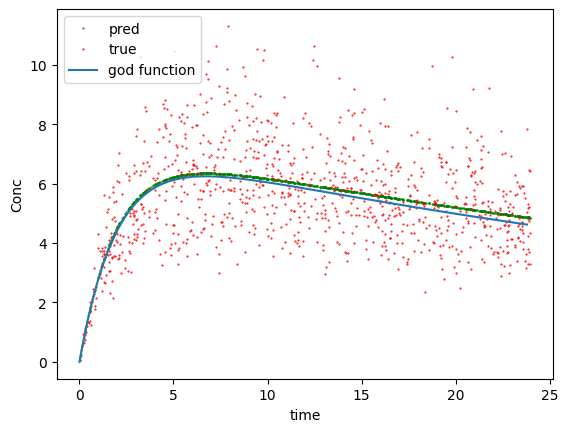

In [159]:
print(f'Here param_(true={param_:.3f}): {model.param_.item():.3f},',
      f'ka({ka}): {model.ka.item():.3f}, k({k}): {model.k.item():.3f}')

plt.plot(inp_list, pred_list, 'go', label='pred', markersize=0.5)
# plt.set_label('predicted values')

plt.plot(inp_list, oup_list,  'ro', label='true', markersize=0.5)
# plt.label('true values')

def conc_time(t):
    return param_ * (np.exp(-1.0 * k * t) - np.exp(-1.0 * ka * t))

plt.plot(time_here, conc_time(time_here), label='god function')
plt.xlabel('time')
plt.ylabel('Conc')

plt.legend(loc=2)
plt.show()